In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
from transformers import AutoTokenizer

In [70]:
pd.set_option('display.max_colwidth', None)

In [2]:
# Lets initially load the data (Kaggle dataset containing different tweets and their sentiment)
tweets_df = pd.read_csv('data/Tweets.csv')
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


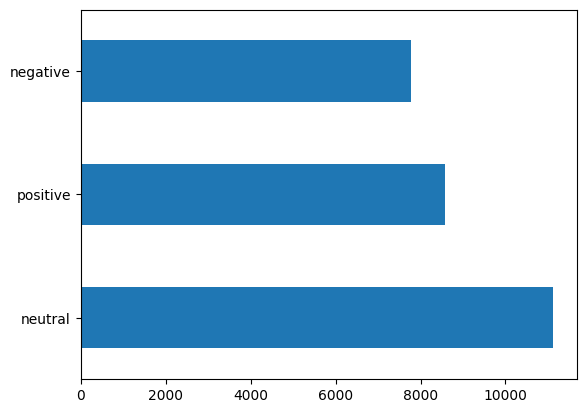

In [3]:
# We have a slightly imbalanced dataset which should be taken into account when evaluating the model/ when we try to split the data into train/test
tweets_df["sentiment"].value_counts().plot.barh()
plt.show()

# 🤗 Transformers

## Create our Dataset

In [4]:
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, DataCollatorWithPadding
from datasets import load_dataset, Dataset, DatasetDict

In [5]:
tweets_ds = load_dataset("csv", data_dir="data/")

Found cached dataset csv (/Users/davidbreinl/.cache/huggingface/datasets/csv/default-8bed6ed4f37d7f15/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
tweets_ds.set_format("pandas")

In [7]:
tweets_df = tweets_ds["train"][:]

In [8]:
tweets_df.drop_duplicates("textID")
tweets_df = tweets_df.dropna()
tweets_df = tweets_df.reset_index()[["text", "sentiment"]] # as I am only interested in the text, and label here
tweets_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


tweets_ds.reset_format()

In [9]:
# Lets encode the sentiment into a numeric representation
class_names = list(tweets_df["sentiment"].unique())
print(class_names)

tweets_df["sentiment"] = [class_names.index(sentiment) for sentiment in tweets_df.sentiment]
tweets_df.head()

['neutral', 'negative', 'positive']


,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


In [10]:
tweets_ds = Dataset.from_pandas(tweets_df)
tweets_ds.reset_format()

In [11]:
train_testvalid = tweets_ds.train_test_split(test_size=0.2, seed=42)

test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

train_testvalid, test_valid

(DatasetDict({
     train: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 21984
     })
     test: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 5496
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 2748
     })
     test: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 2748
     })
 }))

In [12]:
tweets_ds = DatasetDict({
    'train':train_testvalid["train"],
    'test': test_valid["train"],
    'val': test_valid["test"]
})

tweets_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 2748
    })
    val: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 2748
    })
})

## Lets Encode the Text

In [13]:
MODEL_CHKPT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHKPT)

tokenizer("this is a test in order to see if the encoder is working", return_tensors="pt")

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1999,  2344,  2000,  2156,  2065,
          1996,  4372, 16044,  2099,  2003,  2551,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
# We first have to define a function that we can then apply onto our entire huggingface dataset
def tokenize_batch(batch):
    return tokenizer(batch["text"], 
                     padding=True,
                     truncation=True,
                     add_special_tokens=True,
                     return_tensors="pt")

# Lets check if the function is actually working
tokenize_batch(tweets_ds["train"][:2])

{'input_ids': tensor([[  101,  2123,  1036,  1056,  2292,  1996,  3103,  4608,  2017,  6933,
          1011,  2821,  2026,  1012,  1012,  2061,  4658,  8299,  1024,  1013,
          1013,  4714,  3126,  2140,  1012,  4012,  1013, 12731,  6292,  2620,
          2278,   102,     0],
        [  101, 20767,  3251,  2000,  2175,  2000,  2793,  1998,  2707,  3752,
          1996,  2197,  4302, 10693,  2338,  1010,  2130,  2295,  2004,  2574,
          2004,  1045,  2707,  3752,  2009,  1010,  1045,  2180,  1036,  1056,
         10587,  2644,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [15]:
tweets_encoded = tweets_ds.map(tokenize_batch, batched=True, batch_size=None) #batch_size NONE!!!!!!!! Very important since else our tokens are in different lengths
tweets_encoded["train"] # as we can see we now included the input ids and the attention mask

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'sentiment', 'input_ids', 'attention_mask'],
    num_rows: 21984
})

In [16]:
set([len(item) for item in tweets_encoded["train"]["input_ids"]])

{110}

In [17]:
tweets_encoded["train"]["input_ids"][:2]

[[101,
  2123,
  1036,
  1056,
  2292,
  1996,
  3103,
  4608,
  2017,
  6933,
  1011,
  2821,
  2026,
  1012,
  1012,
  2061,
  4658,
  8299,
  1024,
  1013,
  1013,
  4714,
  3126,
  2140,
  1012,
  4012,
  1013,
  12731,
  6292,
  2620,
  2278,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  20767,
  3251,
  2000,
  2175,
  2000,
  2793,
  1998,
  2707,
  3752,
  1996,
  2197,
  4302,
  10693,
  2338,
  1010,
  2130,
  2295,
  2004,
  2574,
  2004,
  1045,
  2707,
  3752,
  2009,
  1010,
  1045,
  2180,
  1036,
  1056,
  10587,
  2644,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [18]:
# since our pytorch model will expect us to input torch tensors lets switch the format

tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "sentiment"])

In [19]:
tweets_encoded["train"][:2]

{'sentiment': tensor([2, 0]),
 'input_ids': tensor([[  101,  2123,  1036,  1056,  2292,  1996,  3103,  4608,  2017,  6933,
           1011,  2821,  2026,  1012,  1012,  2061,  4658,  8299,  1024,  1013,
           1013,  4714,  3126,  2140,  1012,  4012,  1013, 12731,  6292,  2620,
           2278,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101, 20767,  3251,  2000,  2175,  2000,  2793,  1998,  2707,  37

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Create PyTorch Dataloader

In [21]:
from torch.utils.data import DataLoader

In [22]:
BATCH_SIZE=32

train_dataloader= DataLoader(tweets_encoded["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader= DataLoader(tweets_encoded["val"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [23]:
train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff46c0b2f20>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff46c0b2ec0>)

In [24]:
next(iter(train_dataloader))

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'sentiment': tensor([0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 0,
        0, 0, 0, 0, 2, 2, 2, 1]), 'input_ids': tensor([[ 101, 6160, 4402,  ...,    0,    0,    0],
        [ 101, 2128, 1011,  ...,    0,    0,    0],
        [ 101, 1035, 1059,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 2003,  ...,    0,    0,    0],
        [ 101, 7459, 2026,  ...,    0,    0,    0],
        [ 101, 1045, 4299,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Lets now Train a custom Model

In [25]:
model = AutoModel.from_pretrained(MODEL_CHKPT)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
AutoConfig.from_pretrained(MODEL_CHKPT)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

In [27]:
from modeling.model import TweetClassificationModel

In [28]:
model = TweetClassificationModel(checkpoint=MODEL_CHKPT, num_classes=len(class_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
from modeling.train import Model_training
import torch
from transformers import AdamW, get_scheduler

In [30]:
trainer = Model_training(model=model, device=torch.device("mps"))

In [31]:
optimizer=AdamW(model.parameters(), lr=5e-5)

/Users/davidbreinl/opt/anaconda3/envs/learn_huggingface/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
tweets_encoded["train"]["input_ids"]

tensor([[  101,  2123,  1036,  ...,     0,     0,     0],
        [  101, 20767,  3251,  ...,     0,     0,     0],
        [  101,  1045,  1036,  ...,     0,     0,     0],
        ...,
        [  101,  3504,  2066,  ...,     0,     0,     0],
        [  101,  2069,  2038,  ...,     0,     0,     0],
        [  101,  1045,  2467,  ...,     0,     0,     0]])

In [33]:
test_input_ids = tweets_encoded["test"]["input_ids"]
test_attention_masks = tweets_encoded["test"]["attention_mask"]

test_input_ids

tensor([[  101,  1056, 17311,  ...,     0,     0,     0],
        [  101,  2154,  1022,  ...,     0,     0,     0],
        [  101,  2643, 11565,  ...,     0,     0,     0],
        ...,
        [  101,  3407,  2388,  ...,     0,     0,     0],
        [  101,  2055,  2000,  ...,     0,     0,     0],
        [  101, 15933,  2008,  ...,     0,     0,     0]])

In [34]:
# it works but the model clearly overfit on the training data
trainer.train(train_dataloader=train_dataloader,
              eval_dataloader=val_dataloader,
              optimizer=optimizer,
              epochs=2
              )

 50%|█████     | 1/2 [06:19<06:19, 379.21s/it]

Epoch 1:
Train Loss: 0.59257 | Train F1: 0.75164 | Train Acc: 0.75396
Test Loss: 0.54090 | Test F1: 0.77936 | Test Acc: 0.77824



100%|██████████| 2/2 [12:37<00:00, 378.53s/it]

Epoch 2:
Train Loss: 0.41110 | Train F1: 0.83828 | Train Acc: 0.83829
Test Loss: 0.55958 | Test F1: 0.78291 | Test Acc: 0.78083



In [35]:
tweets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])

In [36]:
tweets_encoded["train"]["input_ids"][-1]

tensor([  101,  1045,  2467,  2031,  1037,  2204,  2154,   999,  1045,  2191,
         2009,  2204,  2035,  1996,  2051,  2021,  2017,  2191,  2009,  2488,
         1059,  1013, 24471,  2851, 14806,  2015,   999,   999,  4067,  2017,
          999,   999,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [37]:
tweets_encoded["test"]["input_ids"]

tensor([[  101,  1056, 17311,  ...,     0,     0,     0],
        [  101,  2154,  1022,  ...,     0,     0,     0],
        [  101,  2643, 11565,  ...,     0,     0,     0],
        ...,
        [  101,  3407,  2388,  ...,     0,     0,     0],
        [  101,  2055,  2000,  ...,     0,     0,     0],
        [  101, 15933,  2008,  ...,     0,     0,     0]])

## Lets Evaluate the model on the unseen Test Data

In [44]:
import torch
from torch import nn
from torch.nn.functional import cross_entropy

In [55]:
def forward_pass_with_label(batch):
    with torch.inference_mode():

        inputs = {k:v.to(torch.device("mps")) for k,v in batch.items() if k in tokenizer.model_input_names}

        output = model(input_ids = inputs["input_ids"],
                       attention_mask = inputs["attention_mask"],
                       labels=None)

        pred_label = torch.argmax(output["logits"], dim=1)

        loss = cross_entropy(input=output.logits, target=batch["sentiment"].to(torch.device("mps")), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }



In [56]:
tweets_encoded["test"] = tweets_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

In [57]:
# Now apply to our test data
tweets_encoded["test"]

Dataset({
    features: ['text', 'sentiment', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2748
})

In [58]:
tweets_encoded.set_format("pandas")

In [64]:
#Lets look at the texts with the largest losses -> model had the hardest time predicting

loss_df = tweets_encoded["test"][:][["text", "sentiment", "predicted_label", "loss"]]
loss_df["sentiment"] = [class_names[sentiment] for sentiment in loss_df["sentiment"]]
loss_df["predicted_label"] = [class_names[sentiment] for sentiment in loss_df["predicted_label"]]

In [71]:
loss_df.sort_values("loss", ascending=False).head(20)

,text,sentiment,predicted_label,loss
1504,http://twitpic.com/4w52z - Patrick should come here and say hi!,negative,neutral,7.692671
467,You geek!,negative,positive,7.426255
46,1st presentation for senior boards? FML,negative,neutral,6.605243
2666,eating breakfast getting ready to go to school ;(,negative,neutral,6.484394
2663,have an amazing time with your mommas tomorrow! Show them how much they mean to you Whatever you do they will love it,negative,positive,6.259410
1499,youstinkatrespondingtotexts!,negative,neutral,6.131695
526,msn-ing. no school shouldn`t there be more bank holidays? x,positive,neutral,6.037906
2324,Yep! Tail between legs!,negative,neutral,5.910635
706,Im sure the 5 ppl who came in after me will be seen by a dentist before I will,negative,neutral,5.774485
454,_cunning I gotta go to my cousin`s grad party,positive,neutral,5.719028


In [88]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

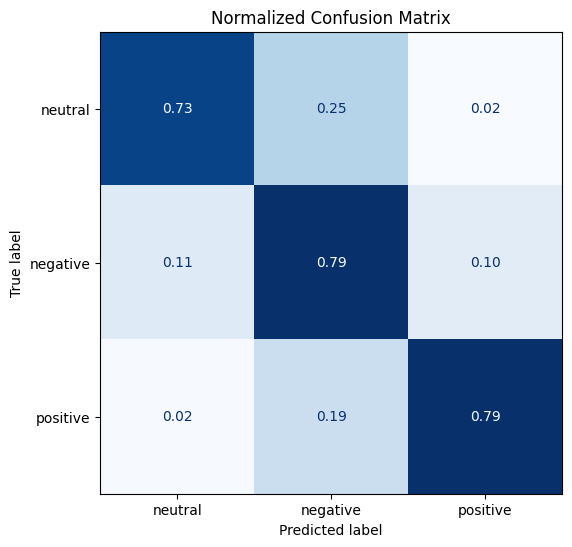

In [89]:
plot_confusion_matrix(loss_df["predicted_label"], loss_df["sentiment"], labels=class_names)

In [87]:
print(f'The accuracy score of the baseline model: {accuracy_score(loss_df["sentiment"], loss_df["predicted_label"])}')
print(f'The f1-score of the baseline model: {f1_score(loss_df["sentiment"], loss_df["predicted_label"], average="weighted")}')

The accuracy score of the baseline model: 0.772197962154294
The f1-score of the baseline model: 0.7729017846297821


## Lets make some predictions on a custom text

In [126]:
from modeling.inference import make_prediction

In [127]:
text = "I think it is amazing that I am now able to classify different tweets"

make_prediction(text=text, model=model, labels=class_names, tokenizer=tokenizer)

'positive'